In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms.functional import to_tensor, to_pil_image
import torch.nn.functional as F
import pickle

In [2]:
# setting up the model
# Define the EdgeConnect model
class EdgeConnect(nn.Module):
    def __init__(self):
        super(EdgeConnect, self).__init__()
        self.edge_model = nn.Sequential(
            nn.Conv2d(4, 64, kernel_size=5, padding=2),  # Input: 4 channels (img + mask), Output: 64 channels
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=5, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 1, kernel_size=5, padding=2),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.completion_model = nn.Sequential(
            nn.Conv2d(5, 64, kernel_size=5, padding=2),  # Input: 5 channels (img + mask + edges), Output: 64 channels
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=5, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 3, kernel_size=5, padding=2),  # Output: 3 channels (RGB image)
            nn.BatchNorm2d(3),
            nn.Sigmoid()
        )

    def forward(self, x):
        edges = self.edge_model(x)  # Forward pass through the edge model

        # Upsample 'edges' to match the spatial dimensions of 'x'
        edges_upsampled = F.interpolate(edges, size=(x.shape[2], x.shape[3]), mode='bilinear', align_corners=False)

        # Concatenate 'x' and the upsampled 'edges'
        completion = self.completion_model(torch.cat([x, edges_upsampled], dim=1))  
        return edges, completion

In [3]:
# Create an instance of the EdgeConnect model
model = EdgeConnect()

In [4]:
# Set the root directory of your dataset
root_dir = 'new_data'

# Define the transforms to apply to the images and masks
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images and masks to tensors
    transforms.Resize((256, 256)),  # Resize images and masks to the target size
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images and masks to be in [-1,1]
    transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))  # Normalize images and masks to be in [0, 1]
])

edge_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert edges to tensors
    transforms.Resize((256, 256)),  # Resize edges to the target size
    transforms.Lambda(lambda x: x.expand(3, -1, -1))  # Convert single-channel image to three channels
])

mask_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert edges to tensors
    transforms.Resize((256, 256))  # Resize edges to the target size
])

class InpaintingDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_transform=None, mask_transform=None, edge_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.edge_transform = edge_transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img = Image.open(os.path.join(self.image_dir, img_name))
        mask_name = img_name.split(".")[0] + "_mask.png"
        mask = Image.open(os.path.join(self.mask_dir, mask_name))
        
        img_array = np.array(img)
        edges = cv2.Canny(img_array, 100, 200)
        edges = Image.fromarray(edges)
        
        if self.image_transform:
            img = self.image_transform(img)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        if self.edge_transform:
            edges = self.edge_transform(edges)
        return img, mask, edges

In [5]:
# Define the training and testing datasets
train_dataset = InpaintingDataset(os.path.join(root_dir, 'original', 'train'),
                                  os.path.join(root_dir, 'mask', 'train'),
                                  image_transform=transform,
                                  mask_transform=mask_transform,
                                  edge_transform=edge_transform)

test_dataset = InpaintingDataset(os.path.join(root_dir, 'original', 'test'),
                                 os.path.join(root_dir, 'mask', 'test'),
                                 image_transform=transform,
                                 mask_transform=mask_transform,
                                 edge_transform=edge_transform)

# Define the data loaders
batch_size = 8  # Set the desired batch size

# Training data loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Testing data loader
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# device = torch.device("cpu")
num_epochs = 50
lr = 0.001

model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [6]:
## For more information into formulation: https://www.youtube.com/watch?v=AZr64OxshLo
## Metric
def dice_coef(y_true, y_pred):
    y_true_f = y_true.reshape(-1)
    y_pred_f = y_pred.reshape(-1)
    intersection = torch.sum(y_true_f * y_pred_f)
    dice = (2. * intersection) / (torch.sum(y_true_f + y_pred_f))
    return dice


In [7]:
# Train the model
model.train()

history = {'loss':[],'dice_coef':[]}

for epoch in range(num_epochs):
    epoch_loss = 0.0
    epoch_dice_coef = 0.0
    num_samples = 0
    
    for i, (img, mask, edges) in enumerate(train_loader):
        img, mask, edges = img.to(device), mask.to(device), edges.to(device)
        
        # Concatenate the image and the mask to form the model's input
        img_with_mask = torch.cat((img, mask), dim=1)
        
        # Generate the edges and the completed image
        edges_gen, img_gen = model(img_with_mask)

        # Expand the dimensions of edges_gen to match the number of channels in edges
        edges_gen = edges_gen.expand_as(edges)

        # Compute the losses
        edge_loss = criterion(edges_gen, edges)
        completion_loss = criterion(img, img_gen)
        
        # Compute the total loss
        loss = edge_loss + completion_loss
        dice = dice_coef(img, img_gen)
              
        epoch_loss += loss.item() * img.size(0)
        epoch_dice_coef += dice.item() * img.size(0)
        num_samples += img.size(0)
        
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i % 10 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}]," \
                  f"Loss: {loss.item()}, Dice_coef: {dice.item()}")
    
    epoch_loss /= num_samples
    epoch_dice_coef /= num_samples

    history['loss'].append(epoch_loss)
    history['dice_coef'].append(epoch_dice_coef)
    
    print(f"Epoch [{epoch + 1}], Loss: {epoch_loss}, Dice_coef: {epoch_dice_coef}")



/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [1/50], Step [1/63],Loss: 0.3573670983314514, Dice_coef: 0.5008561015129089
Epoch [1/50], Step [11/63],Loss: 0.23801884055137634, Dice_coef: 0.5647257566452026
Epoch [1/50], Step [21/63],Loss: 0.23769529163837433, Dice_coef: 0.6274937987327576
Epoch [1/50], Step [31/63],Loss: 0.24518617987632751, Dice_coef: 0.5233043432235718
Epoch [1/50], Step [41/63],Loss: 0.22068637609481812, Dice_coef: 0.5817867517471313
Epoch [1/50], Step [51/63],Loss: 0.2259431630373001, Dice_coef: 0.5562974810600281
Epoch [1/50], Step [61/63],Loss: 0.21916316449642181, Dice_coef: 0.5980288982391357
Epoch [1], Loss: 0.23605696147396452, Dice_coef: 0.5767905485062372
Epoch [2/50], Step [1/63],Loss: 0.22073279321193695, Dice_coef: 0.5956182479858398
Epoch [2/50], Step [11/63],Loss: 0.20921145379543304, Dice_coef: 0.5744302272796631
Epoch [2/50], Step [21/63],Loss: 0.21878717839717865, Dice_coef: 0.5475288033485413
Epoch [2/50], Step [31/63],Loss: 0.21171718835830688, Dice_coef: 0.5911568999290466
Epoch [2/50]

Epoch [13/50], Step [51/63],Loss: 0.08704852312803268, Dice_coef: 0.5610620975494385
Epoch [13/50], Step [61/63],Loss: 0.0823066458106041, Dice_coef: 0.5811765193939209
Epoch [13], Loss: 0.08899991557238594, Dice_coef: 0.5890980457502698
Epoch [14/50], Step [1/63],Loss: 0.08965254575014114, Dice_coef: 0.6031893491744995
Epoch [14/50], Step [11/63],Loss: 0.08581870049238205, Dice_coef: 0.5759405493736267
Epoch [14/50], Step [21/63],Loss: 0.07987186312675476, Dice_coef: 0.576444149017334
Epoch [14/50], Step [31/63],Loss: 0.08537786453962326, Dice_coef: 0.5847993493080139
Epoch [14/50], Step [41/63],Loss: 0.07750649005174637, Dice_coef: 0.5936862826347351
Epoch [14/50], Step [51/63],Loss: 0.08032064139842987, Dice_coef: 0.6387218236923218
Epoch [14/50], Step [61/63],Loss: 0.08299245685338974, Dice_coef: 0.6307899951934814
Epoch [14], Loss: 0.083467545963469, Dice_coef: 0.5882389791428096
Epoch [15/50], Step [1/63],Loss: 0.08071070164442062, Dice_coef: 0.5793015360832214
Epoch [15/50], Ste

Epoch [26/50], Step [11/63],Loss: 0.04420148953795433, Dice_coef: 0.5651660561561584
Epoch [26/50], Step [21/63],Loss: 0.04446246102452278, Dice_coef: 0.5508682131767273
Epoch [26/50], Step [31/63],Loss: 0.04027111455798149, Dice_coef: 0.5772578716278076
Epoch [26/50], Step [41/63],Loss: 0.050354138016700745, Dice_coef: 0.5393053293228149
Epoch [26/50], Step [51/63],Loss: 0.04858766868710518, Dice_coef: 0.6464229226112366
Epoch [26/50], Step [61/63],Loss: 0.044543519616127014, Dice_coef: 0.5835691690444946
Epoch [26], Loss: 0.04414404272323563, Dice_coef: 0.5871332221561008
Epoch [27/50], Step [1/63],Loss: 0.04004747048020363, Dice_coef: 0.6033371090888977
Epoch [27/50], Step [11/63],Loss: 0.05278657376766205, Dice_coef: 0.508621335029602
Epoch [27/50], Step [21/63],Loss: 0.04183521866798401, Dice_coef: 0.579192042350769
Epoch [27/50], Step [31/63],Loss: 0.05100059509277344, Dice_coef: 0.6423850655555725
Epoch [27/50], Step [41/63],Loss: 0.042553216218948364, Dice_coef: 0.6033973693847

Epoch [38/50], Step [41/63],Loss: 0.0416904091835022, Dice_coef: 0.5536558032035828
Epoch [38/50], Step [51/63],Loss: 0.03701069578528404, Dice_coef: 0.5728089213371277
Epoch [38/50], Step [61/63],Loss: 0.03720463812351227, Dice_coef: 0.5999457836151123
Epoch [38], Loss: 0.037509784989413764, Dice_coef: 0.5873704353968302
Epoch [39/50], Step [1/63],Loss: 0.03871321678161621, Dice_coef: 0.5763176679611206
Epoch [39/50], Step [11/63],Loss: 0.03337601572275162, Dice_coef: 0.6119747161865234
Epoch [39/50], Step [21/63],Loss: 0.032317716628313065, Dice_coef: 0.5857933163642883
Epoch [39/50], Step [31/63],Loss: 0.02971704863011837, Dice_coef: 0.5934219360351562
Epoch [39/50], Step [41/63],Loss: 0.03335770219564438, Dice_coef: 0.5948657989501953
Epoch [39/50], Step [51/63],Loss: 0.03065475821495056, Dice_coef: 0.5825687646865845
Epoch [39/50], Step [61/63],Loss: 0.03844175487756729, Dice_coef: 0.5368623733520508
Epoch [39], Loss: 0.03328766472755917, Dice_coef: 0.5898830786583915
Epoch [40/50

Epoch [50], Loss: 0.022328150798640554, Dice_coef: 0.589932748249599


In [8]:
# Save the model checkpoint
torch.save(model.state_dict(), 'retrain0529.pth')

with open('EC_model_hist.pkl', 'wb') as output:
    pickle.dump(history, output)

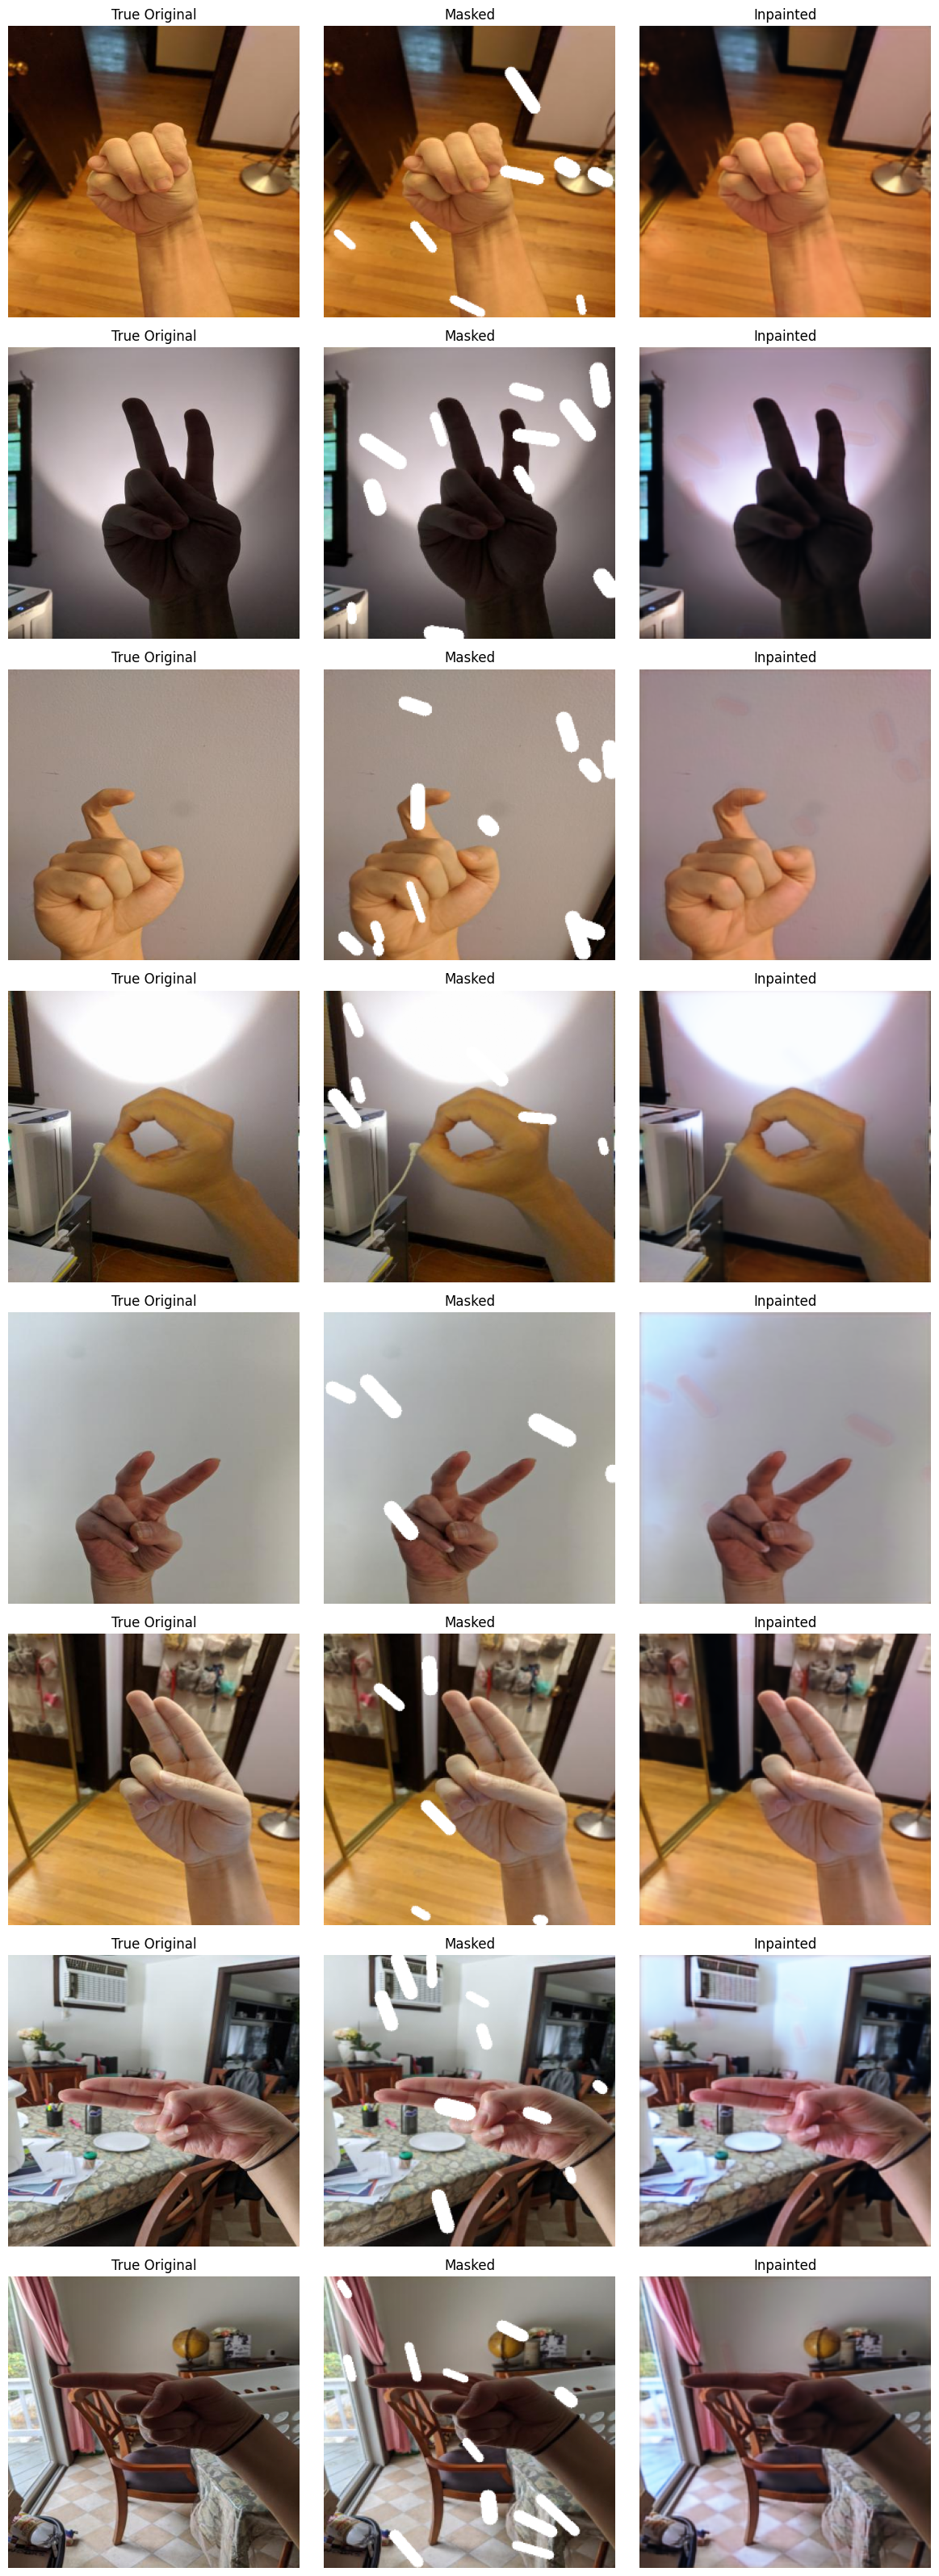

In [15]:
# Look at the result on test


# Set the model to evaluation mode
model.eval()

# Generate inpainted images
with torch.no_grad():
    for i, (img, mask, edge) in enumerate(test_loader):
        img, mask, edge = img.to(device), mask.to(device), edge.to(device)
        img_with_mask = torch.cat((img, mask), dim=1)

        edges, completion = model(img_with_mask)  # Forward pass
        if i == 2:  # Display the 4th batch*
            # Move the images back to the CPU and convert to numpy arrays
            img_with_mask = img_with_mask.cpu().numpy().transpose(0, 2, 3, 1)
            completion = completion.cpu().numpy().transpose(0, 2, 3, 1)
            mask = mask.cpu().numpy().transpose(0, 2, 3, 1)

            # Plot original, masked, and inpainted images
            fig, axs = plt.subplots(img_with_mask.shape[0], 3, figsize=(12, 4 * img_with_mask.shape[0]))
            for j in range(img_with_mask.shape[0]):
                img_name = test_dataset.image_files[i * test_loader.batch_size + j]
                img_path = os.path.join(test_dataset.image_dir, img_name)
                img = Image.open(img_path).convert("RGB")
                img = np.array(img)

                axs[j, 0].imshow(img)
                axs[j, 0].set_title("True Original")
                axs[j, 0].axis("off")
                axs[j, 1].imshow(img_with_mask[j])
                axs[j, 1].set_title("Masked")
                axs[j, 1].axis("off")
                axs[j, 2].imshow(completion[j])
                axs[j, 2].set_title("Inpainted")
                axs[j, 2].axis("off")

            plt.tight_layout()
            plt.show()

        if i >= 4:
            break
        #This code will display the modified image arrangement for the 4th batch of data. The second and third columns will be flipped, and the true original images will be displayed in the first column.

In [ ]:
# Save the model checkpoint
torch.save(model.state_dict(), 'retrain5029.pth')